In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.calibration import CalibratedClassifierCV
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm

In [2]:
df=pd.read_csv('preprocessed_data_fake_real_news.csv')

In [3]:
df.head()

,Unnamed: 0,title,text,subject,date,target,original
0,0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,donald trump just couldn t wish all americans ...
1,1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,house intelligence committee chairman devin nu...
2,2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,on friday it was revealed that former milwauke...
3,3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,on christmas day donald trump announced that h...
4,4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,pope francis used his annual christmas day mes...


In [4]:
X = df.drop(['Unnamed: 0','title','text','subject','date','target'], axis=1)
Y = df['target'].values

In [5]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.33,stratify=Y)
X_train,X_cv,Y_train,Y_cv=train_test_split(X_train,Y_train,test_size=0.33,stratify=Y_train)
print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("Y_train shape:",Y_train.shape)
print("Y_test shape:",Y_test.shape)
print("X_cv shape:",X_cv.shape)
print("Y_cv shape:",Y_cv.shape)

X_train shape: (20154, 1)
X_test shape: (14817, 1)
Y_train shape: (20154,)
Y_test shape: (14817,)
X_cv shape: (9927, 1)
Y_cv shape: (9927,)


In [6]:
#please use below code to load glove vectors 
import pickle
with open("glove_vectors", 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [8]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['original'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [11]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['original']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_train.append(vector)

print(len(tfidf_w2v_vectors_train))
print(len(tfidf_w2v_vectors_train[0]))

100%|████████████████████████████████████████████████████████████████████████████| 20154/20154 [07:32<00:00, 44.52it/s]

20154
300


In [12]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['original']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_cv.append(vector)

print(len(tfidf_w2v_vectors_cv))
print(len(tfidf_w2v_vectors_cv[0]))

100%|██████████████████████████████████████████████████████████████████████████████| 9927/9927 [03:44<00:00, 44.28it/s]

9927
300


In [13]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['original']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_test.append(vector)

print(len(tfidf_w2v_vectors_test))
print(len(tfidf_w2v_vectors_test[0]))

100%|████████████████████████████████████████████████████████████████████████████| 14817/14817 [05:38<00:00, 43.75it/s]

14817
300


# Applying Machine Learning Models

#### a.KNN Classifier

In [14]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(6,4))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(6,4))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(6,4))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [15]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [16]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

for alpha = 5
Log Loss : 0.27947898659778414
for alpha = 11
Log Loss : 0.2744222795686052
for alpha = 15
Log Loss : 0.2760693884790323
for alpha = 21
Log Loss : 0.27867864363560046
for alpha = 31
Log Loss : 0.2824120805759544
for alpha = 41
Log Loss : 0.2850895260572546
for alpha = 51
Log Loss : 0.28843185465906146
for alpha = 99
Log Loss : 0.2967846547488921


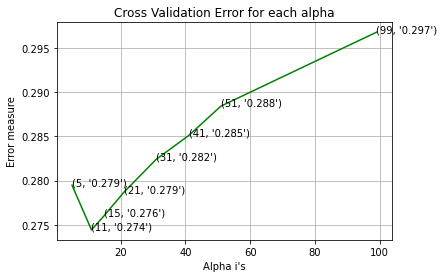

For values of best alpha =  11 The train log loss is: 0.23007927379984275
For values of best alpha =  11 The cross validation log loss is: 0.2744222795686052
For values of best alpha =  11 The test log loss is: 0.2643788725947981


In [17]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(tfidf_w2v_vectors_train,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_w2v_vectors_train,Y_train)
    
    sig_clf_probs = sig_clf.predict_proba(tfidf_w2v_vectors_cv)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(tfidf_w2v_vectors_train,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_w2v_vectors_train,Y_train)

predict_y = sig_clf.predict_proba(tfidf_w2v_vectors_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_w2v_vectors_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_w2v_vectors_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log loss : 0.2744222795686052
Number of mis-classified points : 0.11503979047043417
-------------------- Confusion matrix --------------------


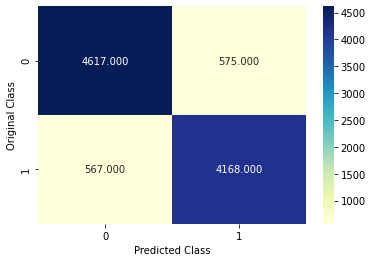

-------------------- Precision matrix (Columm Sum=1) --------------------


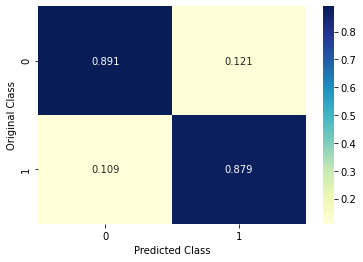

-------------------- Recall matrix (Row sum=1) --------------------


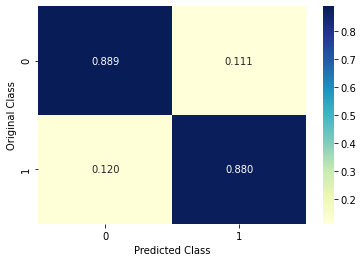

In [18]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(tfidf_w2v_vectors_train,Y_train,tfidf_w2v_vectors_cv, Y_cv, clf)

#### Query point1

In [19]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(tfidf_w2v_vectors_train,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_w2v_vectors_train,Y_train)

test_point_index = 653

predicted_cls = sig_clf.predict(tfidf_w2v_vectors_test[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])
neighbors = clf.kneighbors(tfidf_w2v_vectors_test[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",
      Y_train[neighbors[1][0]])
print("Fequency of nearest points :",Counter(Y_train[neighbors[1][0]]))

Predicted Class : 0
Actual Class : 0
the k value for knn is 11 and the nearest neighbours of the test points belongs to classes [0 0 0 1 0 1 1 0 0 1 0]
Fequency of nearest points : Counter({0: 7, 1: 4})


#### b.Logistic Regression

for alpha = 1e-06
Log Loss : 0.1907548406787304
for alpha = 1e-05
Log Loss : 0.19006601054345656
for alpha = 0.0001
Log Loss : 0.2048356445090349
for alpha = 0.001
Log Loss : 0.25065057182379646
for alpha = 0.01
Log Loss : 0.3202564850286122
for alpha = 0.1
Log Loss : 0.37989655350931506
for alpha = 1
Log Loss : 0.4239463353686365


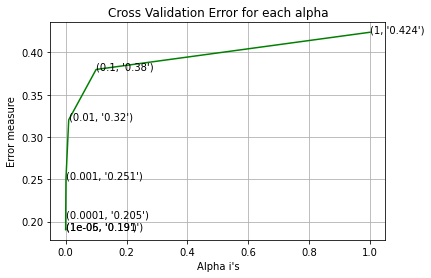

For values of best alpha =  1e-05 The train log loss is: 0.17153630608546477
For values of best alpha =  1e-05 The cross validation log loss is: 0.19006601054345656
For values of best alpha =  1e-05 The test log loss is: 0.1830800823172136


In [23]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(tfidf_w2v_vectors_train,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_w2v_vectors_train,Y_train)
    sig_clf_probs = sig_clf.predict_proba(tfidf_w2v_vectors_cv)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(tfidf_w2v_vectors_train,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_w2v_vectors_train,Y_train)

predict_y = sig_clf.predict_proba(tfidf_w2v_vectors_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_w2v_vectors_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_w2v_vectors_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.19006601054345656
Number of mis-classified points : 0.07252946509519492
-------------------- Confusion matrix --------------------


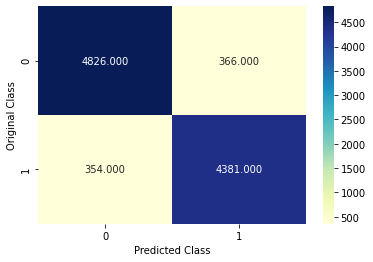

-------------------- Precision matrix (Columm Sum=1) --------------------


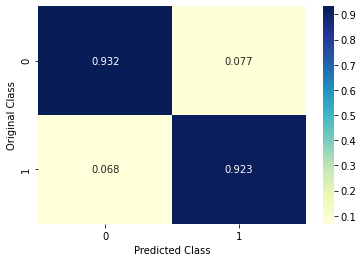

-------------------- Recall matrix (Row sum=1) --------------------


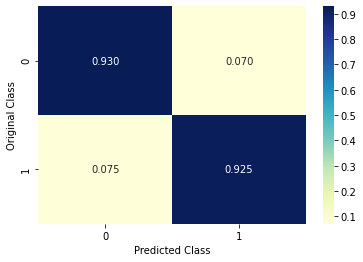

In [24]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(tfidf_w2v_vectors_train, Y_train,tfidf_w2v_vectors_cv, Y_cv, clf)

#### Query point

In [25]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(tfidf_w2v_vectors_train,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_w2v_vectors_train,Y_train)

test_point_index = 899

predicted_cls = sig_clf.predict(tfidf_w2v_vectors_test[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 1
Actual Class : 1


#### c.SVC

for C = 1e-05
Log Loss : 0.19110198395536312
for C = 0.0001
Log Loss : 0.1964114050188965
for C = 0.001
Log Loss : 0.22528572254387028
for C = 0.01
Log Loss : 0.28479466238765694
for C = 0.1
Log Loss : 0.37028785281011234
for C = 1
Log Loss : 0.49067481766052856
for C = 10
Log Loss : 0.5672081031127001
for C = 100
Log Loss : 0.567105751331518


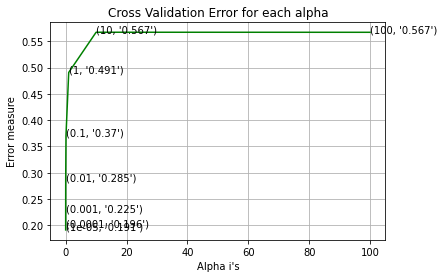

For values of best alpha =  1e-05 The train log loss is: 0.17154993476508323
For values of best alpha =  1e-05 The cross validation log loss is: 0.19110198395536312
For values of best alpha =  1e-05 The test log loss is: 0.18342210724025698


In [26]:
# read more about support vector machines with linear kernals here http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# --------------------------------
# default parameters 
# SVC(C=1.0, kernel=’rbf’, degree=3, gamma=’auto’, coef0=0.0, shrinking=True, probability=False, tol=0.001, 
# cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

# Some of methods of SVM()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/mathematical-derivation-copy-8/
# --------------------------------



# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(tfidf_w2v_vectors_train,Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfidf_w2v_vectors_train,Y_train)
    sig_clf_probs = sig_clf.predict_proba(tfidf_w2v_vectors_cv)
    cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(tfidf_w2v_vectors_train,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_w2v_vectors_train,Y_train)

predict_y = sig_clf.predict_proba(tfidf_w2v_vectors_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_w2v_vectors_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_w2v_vectors_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.190441850876256
Number of mis-classified points : 0.07242872972700715
-------------------- Confusion matrix --------------------


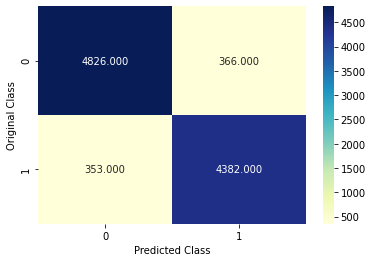

-------------------- Precision matrix (Columm Sum=1) --------------------


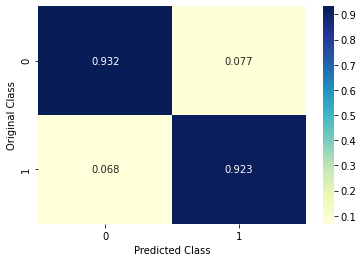

-------------------- Recall matrix (Row sum=1) --------------------


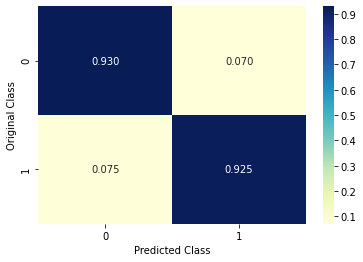

In [27]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(tfidf_w2v_vectors_train, Y_train,tfidf_w2v_vectors_cv, Y_cv, clf)

#### Query point1

In [28]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(tfidf_w2v_vectors_train,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_w2v_vectors_train,Y_train)

test_point_index =1564

predicted_cls = sig_clf.predict(tfidf_w2v_vectors_test[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 1
Actual Class : 1


#### d.Random Forest Classifier

for n_estimators = 100 and max depth =  5
Log Loss : 0.33224939992204544
for n_estimators = 100 and max depth =  10
Log Loss : 0.2627296724129586
for n_estimators = 200 and max depth =  5
Log Loss : 0.3310100082432947
for n_estimators = 200 and max depth =  10
Log Loss : 0.2631410352253048
for n_estimators = 500 and max depth =  5
Log Loss : 0.33244587848123025
for n_estimators = 500 and max depth =  10
Log Loss : 0.2637468423447997
for n_estimators = 1000 and max depth =  5
Log Loss : 0.33280654024845113
for n_estimators = 1000 and max depth =  10
Log Loss : 0.263942626446426
for n_estimators = 2000 and max depth =  5
Log Loss : 0.3325187652486564
for n_estimators = 2000 and max depth =  10
Log Loss : 0.2640014174466551


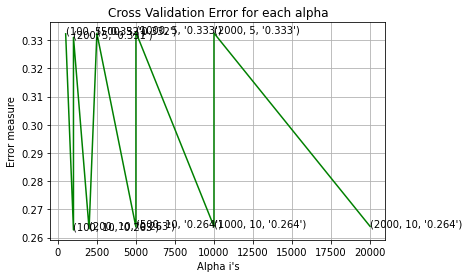

For values of best estimator =  100 The train log loss is: 0.11996824815039529
For values of best estimator =  100 The cross validation log loss is: 0.2627296724129586
For values of best estimator =  100 The test log loss is: 0.2505426562494566


In [29]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(tfidf_w2v_vectors_train,Y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(tfidf_w2v_vectors_train,Y_train)
        sig_clf_probs = sig_clf.predict_proba(tfidf_w2v_vectors_cv)
        cv_log_error_array.append(log_loss(Y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(Y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(tfidf_w2v_vectors_train,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_w2v_vectors_train,Y_train)

predict_y = sig_clf.predict_proba(tfidf_w2v_vectors_train)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_w2v_vectors_cv)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(tfidf_w2v_vectors_test)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 0.2627296724129586
Number of mis-classified points : 0.1066787549108492
-------------------- Confusion matrix --------------------


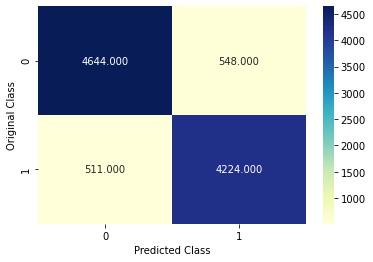

-------------------- Precision matrix (Columm Sum=1) --------------------


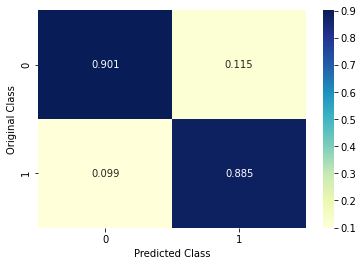

-------------------- Recall matrix (Row sum=1) --------------------


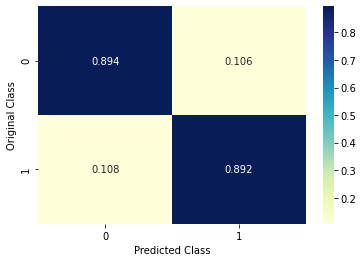

In [30]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], 
                             random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(tfidf_w2v_vectors_train, Y_train,tfidf_w2v_vectors_cv, Y_cv, clf)

#### Query point1

In [31]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(tfidf_w2v_vectors_train,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_w2v_vectors_train,Y_train)

test_point_index = 135
predicted_cls = sig_clf.predict(tfidf_w2v_vectors_test[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 0
Actual Class : 0


#### e.XGBoost Classifier

log_loss for c =  10 is 0.26653567845997567
log_loss for c =  50 is 0.19593165592570266
log_loss for c =  100 is 0.18837365509174656
log_loss for c =  500 is 0.18370055790308032
log_loss for c =  1000 is 0.18303316822324525
log_loss for c =  2000 is 0.18333961620907518


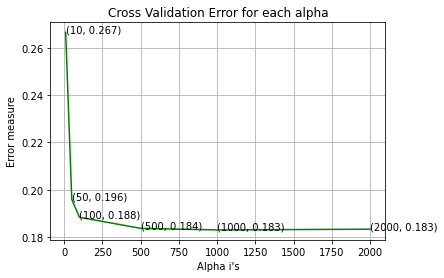

For values of best alpha =  1000 The train log loss is: 0.057540858483892524
For values of best alpha =  1000 The cross validation log loss is: 0.18303316822324525
For values of best alpha =  1000 The test log loss is: 0.17238855483535037


In [33]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------
tfidf_w2v_vectors_train=np.array(tfidf_w2v_vectors_train)
alpha=[10,50,100,500,1000,2000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(tfidf_w2v_vectors_train,Y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(tfidf_w2v_vectors_train,Y_train)
    predict_y = sig_clf.predict_proba(tfidf_w2v_vectors_cv)
    cv_log_error_array.append(log_loss(Y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(tfidf_w2v_vectors_train,Y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(tfidf_w2v_vectors_train,Y_train)
    
predict_y = sig_clf.predict_proba(tfidf_w2v_vectors_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y))
predict_y = sig_clf.predict_proba(tfidf_w2v_vectors_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y))
predict_y = sig_clf.predict_proba(tfidf_w2v_vectors_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y))

Log loss : 0.18303316822324525
Number of mis-classified points : 0.0595346025989725
-------------------- Confusion matrix --------------------


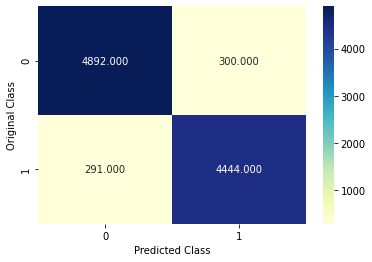

-------------------- Precision matrix (Columm Sum=1) --------------------


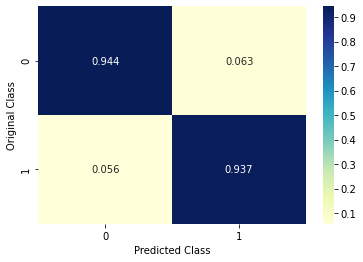

-------------------- Recall matrix (Row sum=1) --------------------


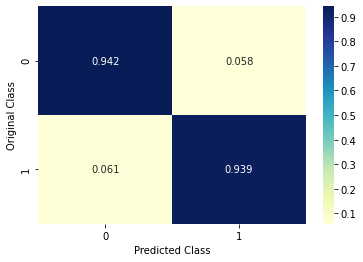

In [34]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------

clf = XGBClassifier(n_estimators=alpha[best_alpha],random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(tfidf_w2v_vectors_train, Y_train,tfidf_w2v_vectors_cv, Y_cv, clf)

#### XgBoost Classification with best hyper parameters using RandomSearch

In [35]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2]}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(tfidf_w2v_vectors_train,Y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed: 12.6min remaining:  7.3min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 12.6min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed: 16.5min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 16.5min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [36]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'max_depth':[3,5,10]}
random_cfl2=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl2.fit(tfidf_w2v_vectors_train,Y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  15 | elapsed:  2.0min remaining: 13.3min
[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  2.1min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  3.4min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  3.5min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  5.3min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  6.5min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  7.0min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [37]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'n_estimators':[100,200,500,1000,2000]}
random_cfl3=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl3.fit(tfidf_w2v_vectors_train,Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed: 18.1min remaining: 16.7min
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed: 28.7min remaining: 16.2min
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed: 39.1min remaining: 12.4min
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed: 47.3min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 51.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 51.4min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [38]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'colsample_bytree':[0.1,0.3,0.5,1]}
random_cfl4=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl4.fit(tfidf_w2v_vectors_train,Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  2.5min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  3.2min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  4.5min remaining:   47.8s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.9min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [39]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()
prams={'subsample':[0.1,0.3,0.5,1]}
random_cfl5=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl5.fit(tfidf_w2v_vectors_train,Y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.8min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  3.5min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  4.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  5.5min remaining:   58.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  5.9min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, reg_alpha=None,
                                           reg_lamb

In [40]:
print(random_cfl1.best_params_)
print(random_cfl2.best_params_)
print(random_cfl3.best_params_)
print(random_cfl4.best_params_)
print(random_cfl5.best_params_)

{'learning_rate': 0.2}
{'max_depth': 5}
{'n_estimators': 2000}
{'colsample_bytree': 1}
{'subsample': 1}


train loss 0.0550925187391916
cv loss 0.17782275223385682
test loss 0.17046478667089057
Log loss : 0.17782275223385682
Number of mis-classified points : 0.05812430744434371
-------------------- Confusion matrix --------------------


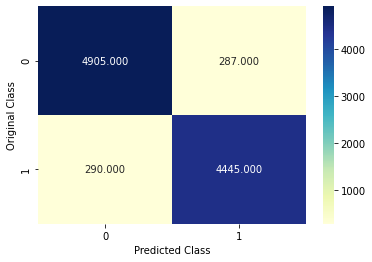

-------------------- Precision matrix (Columm Sum=1) --------------------


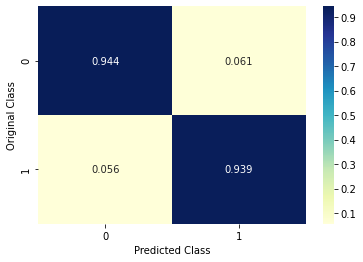

-------------------- Recall matrix (Row sum=1) --------------------


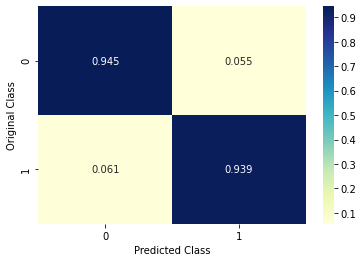

In [41]:
x_cfl=XGBClassifier(n_estimators=2000, learning_rate=0.2, colsample_bytree=1, max_depth=5,subsample=1)
x_cfl.fit(tfidf_w2v_vectors_train,Y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(tfidf_w2v_vectors_train,Y_train)

predict_y = c_cfl.predict_proba(tfidf_w2v_vectors_train)
print ('train loss',log_loss(Y_train, predict_y))
predict_y = c_cfl.predict_proba(tfidf_w2v_vectors_cv)
print ('cv loss',log_loss(Y_cv, predict_y))
predict_y = c_cfl.predict_proba(tfidf_w2v_vectors_test)
print ('test loss',log_loss(Y_test, predict_y))
predict_and_plot_confusion_matrix(tfidf_w2v_vectors_train, Y_train,tfidf_w2v_vectors_cv, Y_cv, x_cfl)

#### Query point

In [42]:
clf=XGBClassifier(n_estimators=2000, learning_rate=0.2, colsample_bytree=1, max_depth=5,subsample=1)
clf.fit(tfidf_w2v_vectors_train,Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfidf_w2v_vectors_train,Y_train)

test_point_index = 5678

predicted_cls = sig_clf.predict(tfidf_w2v_vectors_test[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", Y_test[test_point_index])

Predicted Class : 0
Actual Class : 0
